# Big Data Application: Modeling for Crop Yield Estimation

This jupyter notebook is addressed for creating model that can estimate crop yield in North Dakota, United States. The detail workflow of this project can be seen in [here](https://drive.google.com/file/d/1u3jHTnLqoxMca7SRzgnvGjP-iBvfTnls/view?usp=sharing).

## 0. Install & Load Packages

In [32]:
#install packages
!pip install tensorflow

In [33]:
#load packages

from sklearn.preprocessing import StandardScaler

#packages for manipulating dataframe
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import sklearn

#packages for machine learning
##train-test-split
from sklearn.model_selection import train_test_split, validation_curve

##method 1: Linear Regression (LR)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

##method 2: Random Forest Regressor (RF)
import rfpimp
from sklearn.ensemble import RandomForestRegressor

##method 3: Gradient Boosting Regressor (XGB)
import xgboost
from xgboost import XGBRegressor

##method 4: Artificial Neural Network (ANN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##cross validation
from sklearn.model_selection import GridSearchCV

##evaluation metrics (R2 and RMSE)
from sklearn.metrics import r2_score, mean_squared_error

#data visualization
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

## 1. Load & Cleaning Data

In [34]:
#load data
corn_2018 = pd.read_csv('https://www.dropbox.com/scl/fi/fi5tg278l6gtdk08pvwil/Combined_Summary_By_County_2018_9_Parameters.csv?rlkey=w23aanh5dqvyczfe67bw49qjm&dl=1')
corn_2019 = pd.read_csv('https://www.dropbox.com/scl/fi/hu6n2eo1472q5fr3amt6i/Combined_Summary_By_County_2019_Parameters.csv?rlkey=232te8uu73b5apv3mrsul42i7&dl=1')
corn_2020 = pd.read_csv('https://www.dropbox.com/scl/fi/gf182tns9c30ighnyh2gx/Combined_Summary_By_County_2020_9_Parameters.csv?rlkey=74z3m1505saor7n9zdgnmprnd&dl=1')
corn_2021 = pd.read_csv('https://www.dropbox.com/scl/fi/y8a4ewsgjn8h8ij8ndvdd/Combined_Summary_By_County_2021_9_Parameters.csv?rlkey=fx9pia4medwkfr4minm1up9u1&dl=1')
corn_2022 = pd.read_csv('https://www.dropbox.com/scl/fi/bbpfgz7v4h9zp8wbcajh6/Combined_Summary_By_County_2022_9_Parameters.csv?rlkey=dxehj1e9bhygn6nvkb748n9d2&dl=1')
corn_2023 = pd.read_csv('https://www.dropbox.com/scl/fi/q9lp9gsge46tla76sg6ge/Combined_Summary_By_County_2023_9_Parameters.csv?rlkey=f3nhoewi35iswj3xurfqppipm&dl=1')

In [70]:
corn_list = [corn_2018, corn_2019, corn_2020, corn_2021, corn_2022, corn_2023]
corn_df = pd.concat(corn_list)
corn_df.dropna(inplace=True)
corn_df.YIELD = corn_df.YIELD.astype('float64')

In [71]:
corn_df.reset_index(inplace=True)
corn_df.drop("index", axis = 1, inplace = True)

Text(0.5, 1.0, 'Correlation Matrix')

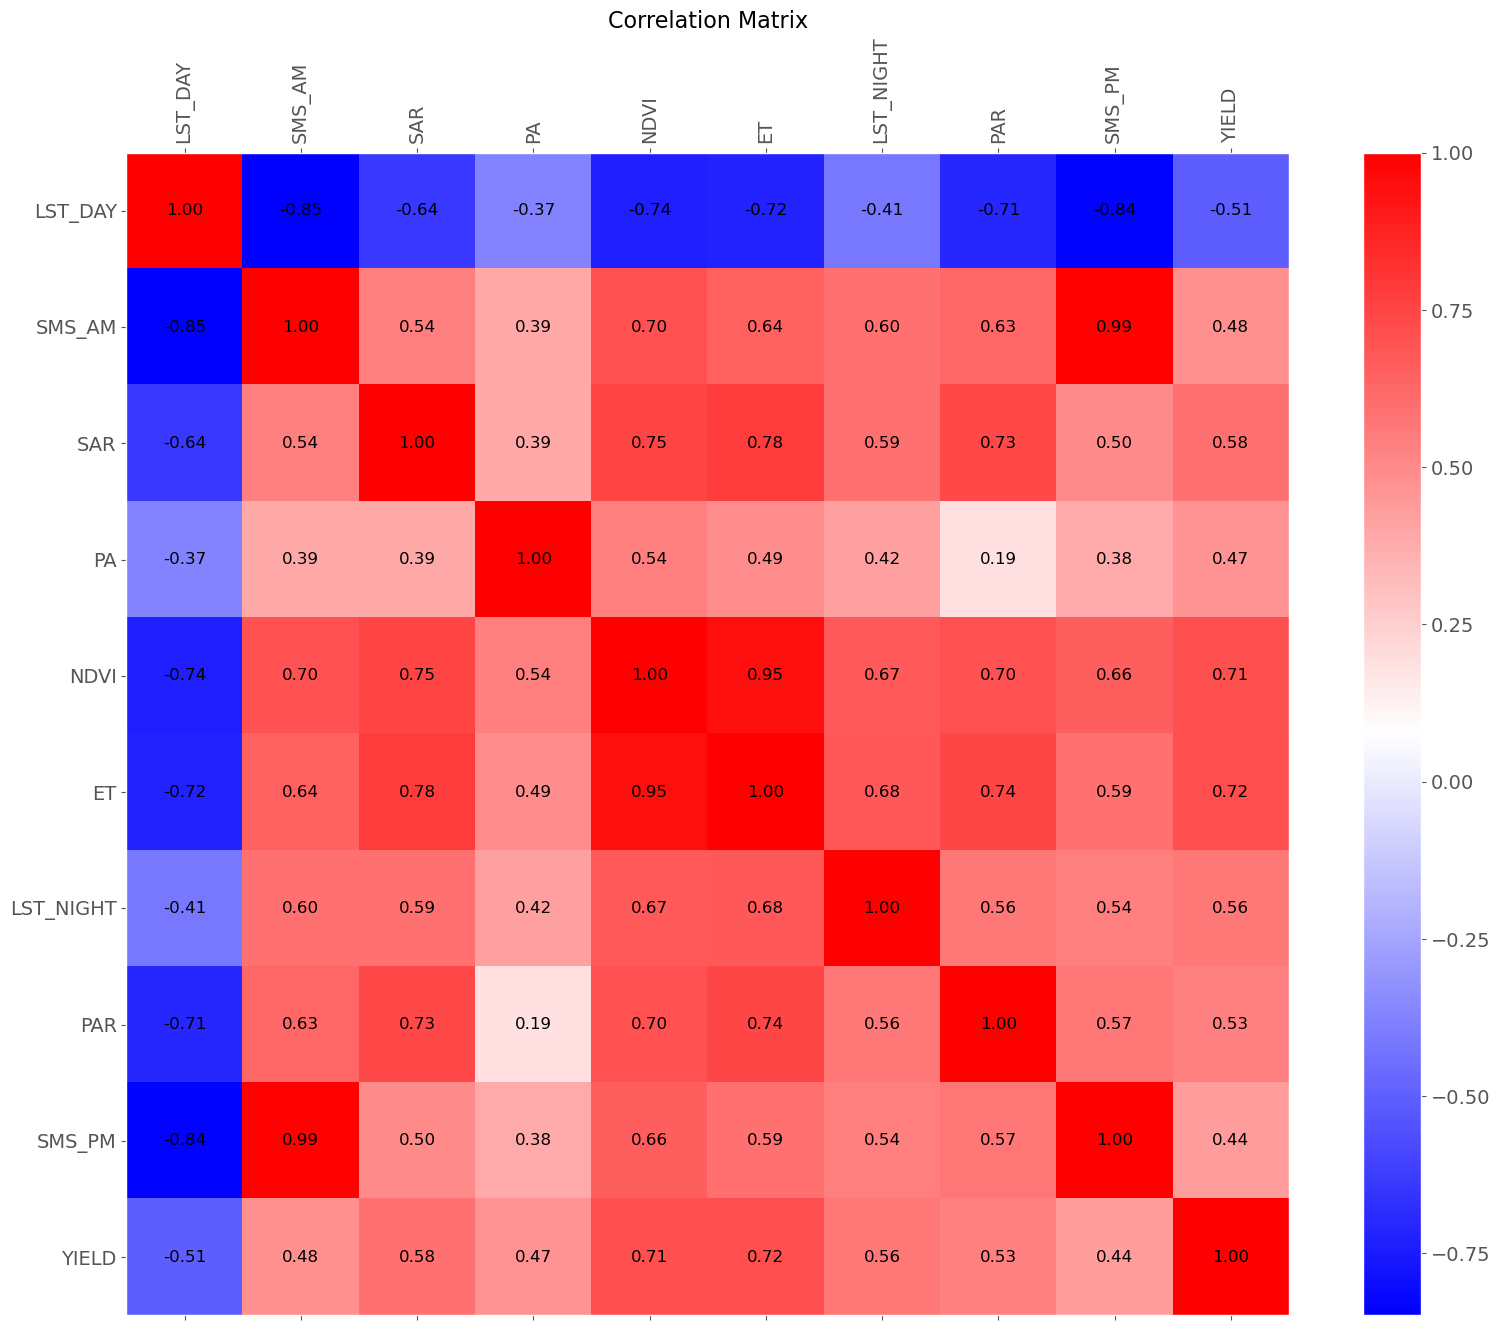

In [6]:
# Correlation coefficients
# correlation_matrix = soybean_df.corr()

# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(19, 15))
# plt.matshow(soybean_df.corr(), fignum=f.number,cmap='bwr')
# plt.xticks(range(soybean_df.shape[1]), soybean_df.columns, fontsize=14, rotation=90)
# plt.yticks(range(soybean_df.shape[1]), soybean_df.columns, fontsize=14)

# for i in range(soybean_df.shape[1]):
#    for j in range(soybean_df.shape[1]):
#        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=12, color='black')

# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)

# plt.savefig('correlation_matrix_soybean.png', bbox_inches='tight')

# plt.title('Correlation Matrix', fontsize=16)

## 2. Train & Test Data Split

In [72]:
corn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         318 non-null    object 
 1   Ag District  318 non-null    object 
 2   GEOID        318 non-null    int64  
 3   NDVI         318 non-null    float64
 4   PA           318 non-null    float64
 5   SAR          318 non-null    float64
 6   SMS_AM       318 non-null    float64
 7   LST_DAY      318 non-null    float64
 8   SMS_PM       318 non-null    float64
 9   LST_NIGHT    318 non-null    float64
 10  PAR          318 non-null    float64
 11  ET           318 non-null    float64
 12  YIELD        318 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 32.4+ KB


In [74]:
#split the dataset
X = corn_df.drop(['YIELD','NAME','Ag District','GEOID','SMS_AM','SMS_PM'], axis=1)
y = corn_df['YIELD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [75]:
X.select_dtypes(include=['number']).columns.to_list()

['NDVI', 'PA', 'SAR', 'LST_DAY', 'LST_NIGHT', 'PAR', 'ET']

In [76]:
#standardized X and Y data accordingly
def standardize_columns(file_name, columns_to_standardize):
    scaler = StandardScaler()

    df = file_name
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    return df

def standardize_series(series):
    scaler = StandardScaler()
    series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
    return series
    
X_columns = X.select_dtypes(include=['number']).columns.to_list()
y_columns = ['YIELD']

X_train = standardize_columns(X_train, X_columns)
X_test = standardize_columns(X_test, X_columns)

#y_train = standardize_series(y_train)
#y_test = standardize_series(y_test)

## 3. Model Training and Parameter Tuning

### 3.1. Linear Regression (LR)

In [77]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

LinearRegression()

### 3.2. Random Forest Regressor (RF)

In [78]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[3,5,10,20,30], 'min_samples_split':[2,4,6,8,10]}


randomState_dt = 100
model_rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(model_rf, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 2}
The best score is: 
0.7278766556902562


In [79]:
# Train the final RF
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=100)

### 3.3. Gradient Boosting Regressor (XGB)

In [80]:
import warnings

# 设置忽略 FutureWarning 类型的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

In [81]:
# model_xgb =
# soybean_df

# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[2,4,6,8,10], 'n_estimators':[4,8,12,16,20]}

randomState_xgb = 100
xgb = XGBRegressor(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.best_score_)

The best parameter value is: 
{'max_depth': 2, 'n_estimators': 20}
The best score is: 
0.7121220343454169


### 3.4. Artificial Neural Network (ANN)

In [84]:
model_ann = keras.Sequential([
    layers.Input(shape=(7,)),  # Input layer
    layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(64, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.3),  # Another dropout layer
    layers.Dense(1)  # Output layer
])

#measuring the training with certain metrics
model_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [85]:
#train the model
model_ann.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0000e+00 - loss: 13492.8203 - val_accuracy: 0.0000e+00 - val_loss: 13332.3604
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 14162.4619 - val_accuracy: 0.0000e+00 - val_loss: 13206.9385
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 13756.4443 - val_accuracy: 0.0000e+00 - val_loss: 13051.2881
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 13332.2607 - val_accuracy: 0.0000e+00 - val_loss: 12844.4424
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 12795.7266 - val_accuracy: 0.0000e+00 - val_loss: 12571.5576
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 12933.5332 - val_accuracy: 0.0000e+00 - val_loss: 12213.5586
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 12052.7168 - val_accuracy: 0.0000e+00 - val_loss: 11749.3467
Epoch 

## 4. Model Evaluation and Performance Comparison

Comparing the performance with using R2 and Root Mean Squared Error (RMSE).

### 4.1. E. Linear Regression (LR)

In [86]:
train_predictions = model_lr.predict(X_train)
test_predictions = model_lr.predict(X_test)

r2_train_lr = r2_score(y_train, train_predictions)
r2_test_lr = r2_score(y_test, test_predictions)

rmse_train_lr = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test_lr = mean_squared_error(y_test, test_predictions, squared=False)

print(f"Training R^2: {r2_train_lr:.4f}")
print(f"Test R^2: {r2_test_lr:.4f}")
print(f"Training RMSE: {rmse_train_lr:.4f}")
print(f"Test RMSE: {rmse_test_lr:.4f}")

Training R^2: 0.7173
Test R^2: 0.7732
Training RMSE: 18.5641
Test RMSE: 16.6800


### 4.2. E. Random Forest Regressor (RF)

In [87]:
r2_train_rf = rf_final.score(X=X_train, y=y_train)
r2_test_rf = rf_final.score(X=X_test, y=y_test)

print("R2 on the training data:")
print(r2_train_rf)
print("R2 on the testing data:")
print(r2_test_rf)

R2 on the training data:
0.9642508395150555
R2 on the testing data:
0.8124597634000534


In [88]:
rmse_train_rf = mean_squared_error(y_train, rf_final.predict(X_train), squared=False)
rmse_test_rf = mean_squared_error(y_test, rf_final.predict(X_test), squared=False)

print("RMSE on the training data:")
print(rmse_train_rf)
print("RMSE on the testing data:")
print(rmse_test_rf)

RMSE on the training data:
6.601176994035226
RMSE on the testing data:
15.166271795818888


                                        Importance
Feature                                           
NDVI                                        0.6072
LST_DAY                                     0.0911
ET                                          0.0833
PAR                                         0.0537
SAR                                         0.0277
PA                                          0.0200
LST_NIGHT                                   0.0041


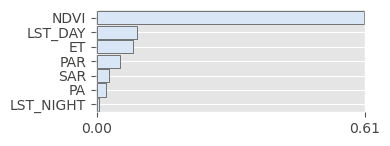

In [89]:
# Calculate and plot the feature importance of the RF model
imp = rfpimp.importances(rf_final, X_test, y_test)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 4.3. E. Gradient Boosting Regressor (XGB)

In [90]:
model_xgb = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=100, ...)

In [91]:
# r2_train_xgb, r2_test_xgb, rmse_train_xgb, rmse_test_xgb
r2_train_xgb = model_xgb.score(X=X_train, y=y_train)
r2_test_xgb = model_xgb.score(X=X_test, y=y_test)
rmse_train_xgb = mean_squared_error(y_train, model_xgb.predict(X_train), squared=False)
rmse_test_xgb = mean_squared_error(y_test, model_xgb.predict(X_test), squared=False)

In [92]:
print("R2 on the training data:")
print(r2_train_xgb)
print("R2 on the testing data:")
print(r2_test_xgb)

R2 on the training data:
0.8632947936612397
R2 on the testing data:
0.7945931877980402


In [93]:
print("RMSE on the training data:")
print(rmse_train_xgb)
print("RMSE on the testing data:")
print(rmse_test_xgb)

RMSE on the training data:
12.908654618048486
RMSE on the testing data:
15.872269404332858


                                        Importance
Feature                                           
NDVI                                        0.3331
LST_DAY                                     0.1103
ET                                          0.0842
LST_NIGHT                                   0.0387
PAR                                         0.0189
PA                                          0.0187
SAR                                        -0.0010


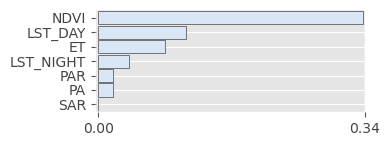

In [94]:
imp_xgb = rfpimp.importances(model_xgb, X_test, y_test) # permutation
print(imp_xgb)
viz_xgb = rfpimp.plot_importances(imp_xgb)
viz_xgb.view()

### 4.4. E. Artificial Neural Network (ANN)

In [95]:
#predictions
y_pred_train_ann = model_ann.predict(X_train).flatten()
y_pred_test_ann = model_ann.predict(X_test).flatten()

#Compute R2 and RMSE
r2_train_ann = np.round(r2_score(y_train, y_pred_train_ann),2)
r2_test_ann = np.round(r2_score(y_test, y_pred_test_ann),2)
rmse_train_ann = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train_ann)),2)
rmse_test_ann = np.round(np.sqrt(mean_squared_error(y_test, y_pred_test_ann)),2)

#print the result
print("Train R2:", r2_train_ann)
print("Test R2:", r2_test_ann)
print("Train RMSE:", rmse_train_ann)
print("Test RMSE:", rmse_test_ann)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train R2: 0.72
Test R2: 0.73
Train RMSE: 18.61
Test RMSE: 18.14


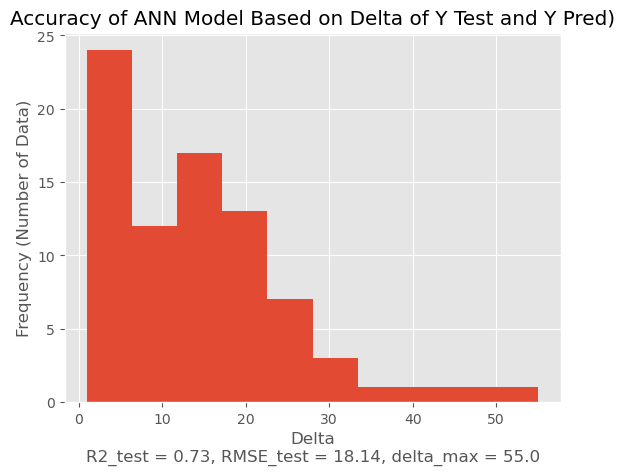

In [96]:
#crosscheck the y value between real and predicted
crosscheck_y_dict = {
    'y_test' : y_test,
    'y_pred' : np.round(y_pred_test_ann,0),
    'delta' : np.abs(np.round((y_test - y_pred_test_ann),0))
}

#plotting histogram
crosscheck_y_df = pd.DataFrame(crosscheck_y_dict)
plt.hist(crosscheck_y_df['delta'], bins=10)
plt.xlabel(f'Delta\nR2_test = {r2_test_ann}, RMSE_test = {rmse_test_ann}, delta_max = {crosscheck_y_df.delta.max()}')
plt.ylabel('Frequency (Number of Data)')
plt.title(f"Accuracy of ANN Model Based on Delta of Y Test and Y Pred)")
plt.show()

### 4.5. Model Performance Comparison

In [97]:
#please input your metrics in here
metrics_dict = {
    'metrics': ["Train R2","Test R2","Train RMSE","Test RMSE"],
    'LR': [r2_train_lr, r2_test_lr, rmse_train_lr, rmse_test_lr],
    'RF': [r2_train_rf, r2_test_rf, rmse_train_rf, rmse_test_rf],
    'XGB': [r2_train_xgb, r2_test_xgb, rmse_train_xgb, rmse_test_xgb],
    'ANN': [r2_train_ann, r2_test_ann, rmse_train_ann, rmse_test_ann]
}

#create dataframe
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('metrics')

,LR,RF,XGB,ANN
metrics,,,,
Train R2,0.7173,0.9643,0.8633,0.7200
Test R2,0.7732,0.8125,0.7946,0.7300
Train RMSE,18.5641,6.6012,12.9087,18.6100
Test RMSE,16.6800,15.1663,15.8723,18.1400


Based on the comparison, it can be said that the best model that can be used for estimating crop yield is []. From this point, [] model would be used for estimation phase (step 5).

## 5. Crop Yield Estimation and Export Result